In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from particletracking import dataframes
from tqdm import tqdm

In [2]:
%matplotlib inline

### Load the datasets

In [158]:
data_flat = dataframes.DataStore("/media/data/Data/FirstOrder/Susceptibility/Flat2/17510001.hdf5")
flat_points = data_flat.df.loc[0].copy()

data_dimpled = dataframes.DataStore("/media/data/Data/FirstOrder/Susceptibility/Dimpled2/17490001.hdf5") 
dimpled_points = data_dimpled.df.loc[0].copy()

### Get all the vectors between the points

In [4]:
def get_delaunay_vectors(points):
    tri = spatial.Delaunay(points[['x', 'y']])
    triangles = tri.points[tri.simplices]
    vecs = np.array([t - t[[2, 0, 1], :] for t in triangles])
    vecs = vecs.reshape((-1, 2))
    return vecs

In [5]:
flat_vecs = get_delaunay_vectors(flat_points)
dimpled_vecs = get_delaunay_vectors(dimpled_points)

### Get all the angles of the vectors

In [6]:
def get_delaunay_angles(vecs):
    return np.arctan(vecs[:, 1]/vecs[:, 0])

In [7]:
flat_angles = get_delaunay_angles(flat_vecs)
dimpled_angles = get_delaunay_angles(dimpled_vecs)

/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


### Calculate the correct angle

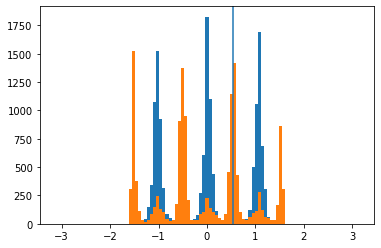

In [8]:
_, _, _ = plt.hist(flat_angles, bins=np.linspace(-np.pi, np.pi, 100))
_, _, _ = plt.hist(dimpled_angles, bins=np.linspace(-np.pi, np.pi, 100))
plt.axvline(np.median(dimpled_angles[(dimpled_angles>0)&(dimpled_angles<np.pi/3)]))

In [9]:
def get_delaunay_angle(angles, flat=False):
    if flat:
        angles = angles[[(angles>-np.pi/4)&(angles<np.pi/4)]]
    else:
        angles = angles[[(angles>0)&(angles<np.pi/3)]]
    return np.median(angles)*180 / np.pi

In [10]:
flat_angle = get_delaunay_angle(flat_angles, True)
dimpled_angle = get_delaunay_angle(dimpled_angles, False)
flat_angle, dimpled_angle

/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


(1.3019526725788753, 30.96375653207352)

### Calculate the correct length

In [11]:
def get_delaunay_lengths(vecs):
    lengths = np.linalg.norm(vecs, axis=1)
    return lengths

In [12]:
flat_lengths = get_delaunay_lengths(flat_vecs)
dimpled_lengths = get_delaunay_lengths(dimpled_vecs)

In [13]:
def get_delaunay_length(lengths):
    return np.median(lengths)

In [14]:
flat_length = get_delaunay_length(flat_lengths)
dimpled_length = get_delaunay_length(dimpled_lengths)

### Calculate G

In [15]:
def get_G(length, angle):
    """Get G from the lengthscale of the lattice and the angle in degrees"""
    a = (angle+90) * np.pi/180 
    cosa = np.cos(a)
    sina = np.sin(a)
    l = 4*np.pi / (length * np.sqrt(3))
    return np.array((cosa, sina))*l

In [16]:
flat_G = get_G(flat_length, flat_angle)
dimpled_G = get_G(dimpled_length, dimpled_angle)

### Calculate translational order

In [17]:
def add_torder(data, G):
    data['torder'] = np.exp(1j* data[['x', 'y']].values@G)
    return data

In [18]:
flat_points = add_torder(flat_points, flat_G)

In [19]:
dimpled_points = add_torder(dimpled_points, dimpled_G)

### Calculate for all frames

In [159]:
data_dimpled.df = add_torder(data_dimpled.df, dimpled_G)

In [98]:
def add_complex_order(d):
    d['order_complex_long'] = d.order_r_long+1j*d.order_i_long
    return d

In [99]:
data_dimpled.df = add_complex_order(data_dimpled.df)

In [21]:
data_flat.df = add_torder(data_flat.df, flat_G)

### Plot torder

In [171]:
def quiver_torder(data):
    torder = data.torder.values
    plt.quiver(data.x, data.y, torder.real, torder.imag, np.angle(torder), pivot='mid', cmap='hsv')
    plt.clim([-np.pi, np.pi])
    plt.colorbar()

In [173]:
quiver_torder(flat_points)

### Calculate the susceptibility

In [25]:
%matplotlib auto
plt.plot(flat_points.x, flat_points.y)

Using matplotlib backend: Qt5Agg


### Make subboxes

In [30]:
xmin = 500
xmax = 1700
ymin = 500
ymax = 1700
dx = xmax-xmin
dy = ymax-ymin

In [49]:
def generate_subboxes(n):
    boxes = [[xmin+b*dx//(n), xmin+(b+1)*dx//(n), ymin+b*dy//(n), ymin+(b+1)*dy//(n)] for b in range(n)]
    return boxes

In [147]:
def mean_frame_values(pts, param):
    vals = pts[param].values
    return np.mean(vals)

In [161]:
def sus_of_dataframe(data, param, box):
    xmin, xmax, ymin, ymax = box
    d = data.df.loc[(data.df.x>xmin)&(data.df.x<xmax)&(data.df.y>ymin)&(data.df.y<ymax)]
    means = d.groupby('frame').apply(mean_frame_values, param)
    sus = np.mean(means * np.conj(means)) - np.mean(means)*np.conj(np.mean(means))
    return sus.real

In [183]:
def get_sus(data, param, n):
    sus = []
    ns = []
    for ni in range(1, n+1):
        subboxes = generate_subboxes(ni)
        sus_n = [sus_of_dataframe(data, param, s) for s in subboxes]
        sus.append(np.mean(sus_n))
        ns.append(ni)
    ns = np.array(ns)
    sus = np.array(sus)
    plt.plot(ns, sus)
    fit, cov = np.polyfit(ns, sus, 2, cov=True)
    err = np.sqrt(np.diag(v))
    return fit[2], err[2]

In [184]:
%%time
get_sus(data_flat, 'torder', 6)

CPU times: user 2.79 s, sys: 11.3 ms, total: 2.81 s
Wall time: 1.99 s


(-0.021377945163984224, 0.00023414969735081914)

### Calculate the susceptibility for all dataframes to plot the graph

In [127]:
def duty(data):
    return int(data.df.Duty.mean())

In [128]:
import filehandling

In [129]:
flat_files = filehandling.get_directory_filenames("/media/data/Data/FirstOrder/Susceptibility/Flat2/*.hdf5")

In [130]:
dimpled_files = filehandling.get_directory_filenames("/media/data/Data/FirstOrder/Susceptibility/Dimpled2/*.hdf5")

In [167]:
def process_file(f, G):
    data = dataframes.DataStore(f)
    data.df = add_torder(data.df, G)
    data.save()
    d = duty(data)
    sus, sus_err = get_sus(data, 'torder', 6)
    return d, sus, sus_err

In [176]:
flat_duties = []
flat_sus = []
flat_sus_err = []
for f in tqdm(flat_files):
    d, sus, sus_err = process_file(f, flat_G)
    flat_duties.append(d)
    flat_sus.append(sus)

100%|██████████| 100/100 [07:22<00:00,  4.42s/it]


In [139]:
flat_sus_value, flat_sus_error = zip(*flat_sus)

In [181]:
plt.errorbar(flat_duties, flat_sus, yerr=flat_sus_error)

<ErrorbarContainer object of 3 artists>